# Evalution of vmango-lab simulations

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import xsimlab as xs
import xsimlab.dot as dot
import ipywidgets as iw
from importlib import resources

import vmlab
from vmlab.models import *

In [2]:
import vmlab.processes.phenology as phenology
import vmlab.processes.environment as environment
my_arch_dev = arch_dev_model
my_arch_dev = my_arch_dev.update_processes({'phenology': phenology.Phenology, 'environment': environment.Environment})

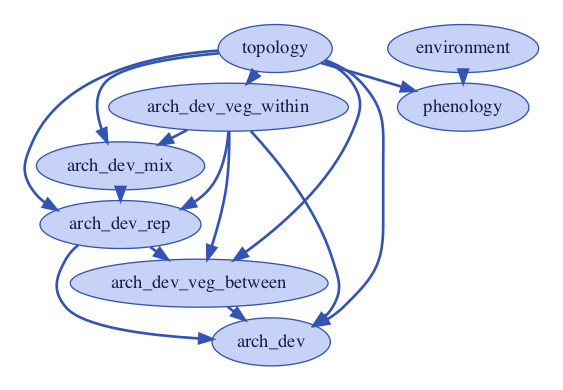

In [3]:
dot.dot_graph(my_arch_dev,
              show_inputs=False,
              rankdir='TB',
              graph_attr = {'margin':'0.2', 'nodesep':'0.1', 'ranksep':'0.1'})

## 1. Run simulations for the three trees (B10, B12 and F2)

In [4]:
start_date='2003-06-01'
end_date='2005-12-01'

In [5]:
def create_setup(tree):
    return vmlab.create_setup(
        model=vmango,
        tree=tree,   
        start_date=start_date,
        end_date=end_date,
        setup_toml='vmango.toml',
        current_cycle=3,
        input_vars={
            'topology__seed': 10,
            'geometry__interpretation_freq': 30
        },
        output_vars={
            'topology': {
                'appearance_date': 'day',
                'appearance_month':'day',
                'appeared':'day',               
                'cycle': None,
                'adjacency' : None,
                'is_apical' : None
            },
            'phenology':{
                'flowered':'day',
            },
            'arch_dev': {
                'pot_flowering_date' : 'day',
                'pot_nb_fruit': 'day'

            },
            'arch_dev_rep': {
                'flowering': 'day',
                'flowering_date' : 'day',
                'flowering_week' : 'day',
                'fruiting':'day',
                'nb_fruits':'day'
            }               
        }
    )


- **Tree B10**

In [6]:
with resources.path('vmlab.data.trees', 'tree_B10_cycle_030405.csv') as path:
    tree = pd.read_csv(path)

setup = create_setup(tree)

ds_out_B10 = vmlab.run(setup, vmango, geometry = False)

             0% | initialize 

- **Tree B12**

In [7]:
with resources.path('vmlab.data.trees', 'tree_B12_cycle_030405.csv') as path:
    tree = pd.read_csv(path)

setup = create_setup(tree)

ds_out_B12 = vmlab.run(setup, vmango, geometry = False)

             0% | initialize 

- **Tree F2**

In [8]:
with resources.path('vmlab.data.trees', 'tree_F2_cycle_030405.csv') as path:
    tree = pd.read_csv(path)

setup = create_setup(tree)

ds_out_F2 = vmlab.run(setup, vmango, geometry = False)

             0% | initialize 

## 2. Evaluation

The goal of this notebook is to reproduce the results from original paper. For the following diagram, only one set of 3 trees is considered.

![archdev_result](vmango_original_archdev_results.jpeg)

### 2.1. Vegetative growth

In [9]:
def apply_to_all_ds(func):
    result = None
    for ds_out in [ds_out_B10, ds_out_B12, ds_out_F2]:
        lresult = func(ds_out)
        if result is None:
            result = lresult
        else:
            result = result.add(lresult, fill_value=0) 
    return result

In [10]:
def vegetative_appearance(ds_out):
    appearance_date = ds_out.topology__appearance_date.where(ds_out.topology__appeared == 1).groupby(ds_out.topology__appearance_date)
    appearance_date = appearance_date.count().to_dataframe().reindex(pd.date_range(start=start_date, end=end_date, freq='MS'))
    return appearance_date.rename(columns={"topology__appearance_date": "1 simulation"})

appearance_date = apply_to_all_ds(vegetative_appearance)


In [11]:
from numpy import datetime64 as datetime
measured_histogram = [((2003, 5), 0), ((2003, 6), 1), ((2003, 7), 1), ((2003, 8), 0), ((2003, 9), 33), ((2003, 10), 240), ((2003, 11), 71), ((2003, 12), 329), ((2004, 1), 126), ((2004, 2), 323), ((2004, 3), 21), ((2004, 4), 61), ((2004, 5), 7), ((2004, 6), 3), ((2004, 7), 0), ((2004, 8), 213), ((2004, 9), 55), ((2004, 10), 31), ((2004, 11), 144), ((2004, 12), 15), ((2005, 1), 85), ((2005, 2), 723), ((2005, 3), 1189), ((2005, 4), 0)]
def todate(y,m):
    return datetime(str(y)+'-'+str(m).zfill(2)+'-01')
from pandas import DataFrame
measured_histogram = DataFrame({'Observations' : [v for k,v in measured_histogram]}, index = [todate(*k) for k,v in measured_histogram])
measured_histogram = measured_histogram.reindex(appearance_date.index)


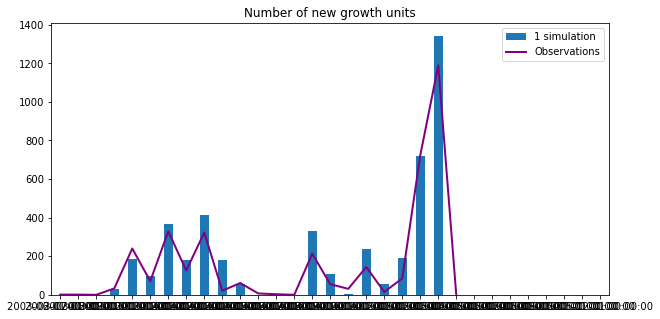

In [12]:
fig, axes = plt.subplots(figsize=(10,5))
appearance_date.plot.bar( ax=axes)
measured_histogram.plot(ax=axes, color='purple', linewidth=2, use_index=False)
plt.title('Number of new growth units')
plt.show()

**Figure A. Monthly demography of new growth units (GUs) for growing cycles 1 and 2**

Blue histogram and purple line represent respectively the simulations and observed data summed over the three mango trees (B10, B12 and F2)

### 2.2. Flowering

#### Number of new inflorescences at the full bloom stage for cycle 2

In [13]:
x_range = list(range(30,51,1))

def full_bloom(ds_out):
    flowering_date_tree = ds_out.arch_dev__pot_flowering_date.where(ds_out.phenology__flowered == 1).groupby(ds_out.arch_dev__pot_flowering_date)
    flowering_date_tree = flowering_date_tree.count().to_dataframe()
    df_week = flowering_date_tree.index.isocalendar()[['year','week']]
    df = flowering_date_tree.join(df_week)
    df = df[df['year'] == 2005].drop(labels=['year'],axis=1).groupby(['week']).sum().reindex(x_range)
    return df.rename(columns={"arch_dev__pot_flowering_date": "1 simulation"})

flowering_date = apply_to_all_ds(full_bloom)


In [14]:
bloom_date2005 = [((2005, 26), 0), ((2005, 27), 0), ((2005, 28), 0),  ((2005, 29), 0),((2005, 30), 0),
             ((2005, 31), 1), ((2005, 32), 22), ((2005, 33), 3), ((2005, 34), 15), ((2005, 35), 108),
             ((2005, 36), 487), ((2005, 37), 161), ((2005, 38), 204), ((2005, 39), 142),
             ((2005, 40), 49), ((2005, 41), 34), ((2005, 42), 11),  ((2005, 43), 7)]
bloom_date2005 = DataFrame({'Observations' : [v for k,v in bloom_date2005]}, 
                           index = [w for (y,w),v in bloom_date2005])
bloom_date2005 = bloom_date2005.reindex(flowering_date.index)


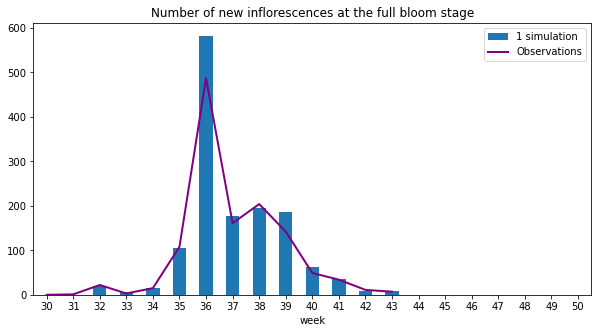

In [15]:
axes = flowering_date.plot.bar(figsize=(10,5))
bloom_date2005.plot.line(ax=axes, color='purple', linewidth=2, use_index=False)
_= plt.title('Number of new inflorescences at the full bloom stage')

### 2.3. Fruiting

#### Number of new fruits in 2004 and 2005 (cycles 2 and 3)

In [16]:
def nbfruits_estimation(ds_out):
    nb_fruits_tree = ds_out.arch_dev__pot_nb_fruit.max(dim="day").to_dataframe()
    flowering_date = ds_out.arch_dev__pot_flowering_date.where(ds_out.topology__appeared == 1).to_dataframe().dropna()
    df = nb_fruits_tree.join(flowering_date)
    df = df.loc[df.index.repeat(df.arch_dev__pot_nb_fruit)].groupby(['arch_dev__pot_flowering_date']).count()
    df_year = df.index.isocalendar()[['year']]
    df = df.join(df_year)
    df = df.groupby(['year']).sum()
    return df.rename(columns={"arch_dev__pot_nb_fruit": "1 simulation"})

nb_fruits = apply_to_all_ds(nbfruits_estimation)
nb_fruits


,1 simulation
year,
2004,326
2005,601


In [17]:
nbmeasuredfruits = DataFrame({'Observations':[302, 400]},index=nb_fruits.index)
nbmeasuredfruits

,Observations
year,
2004,302
2005,400


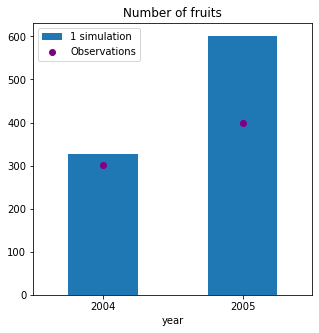

In [18]:
fig, axes = plt.subplots(figsize=(5,5))
ax = nb_fruits.plot.bar(ax=axes)
nbmeasuredfruits.plot(style='o',ax=axes,color='purple',  use_index=False)
_ = plt.title('Number of fruits')

### 4. Distribution of axis lengths 

Axis length is expressed in number of successive apical GUs. 


*Bug found in the estimation of the histogram of branch length in the original paper.*


In [19]:
from scipy.sparse import csgraph

def compute_axis_lengths(ds):
    adjacency = np.array(ds.topology__adjacency.data)
    cycle = ds.topology__cycle
    is_lateral = ds.topology__is_apical == False

    # Remove link between lateral children and their parent
    adjacency[:,is_lateral] = 0

    # Change topology so that node from cycle 3 are not considered
    adjacency = adjacency[cycle > 3][:, cycle > 3]

    # determine connected components to identify branches
    n_components, labels = csgraph.connected_components(adjacency)
    
    # determine branch length from labels
    branch_length = np.bincount(labels)
    
    # determine branch length histogram from branch length
    branch_length_histogram = np.bincount(branch_length)
    return DataFrame({'1 simulation':branch_length_histogram[1:]},
                     index = list(range(1,len(branch_length_histogram))))

In [20]:
lengthdistribution = apply_to_all_ds(compute_axis_lengths)
lengthdistribution

,1 simulation
1,2490.0
2,542.0
3,199.0
4,58.0
5,16.0
6,2.0


In [21]:
measuredlengthdistribution = DataFrame({'Observations' : [2347, 351, 197, 35, 16, 4]}, index=list(range(1,7)))
if len(lengthdistribution.index ) >= len(measuredlengthdistribution.index ):
    measuredlengthdistribution = measuredlengthdistribution.reindex(lengthdistribution.index)
else:
    lengthdistribution = lengthdistribution.reindex(measuredlengthdistribution.index)

measuredlengthdistribution

,Observations
1,2347
2,351
3,197
4,35
5,16
6,4


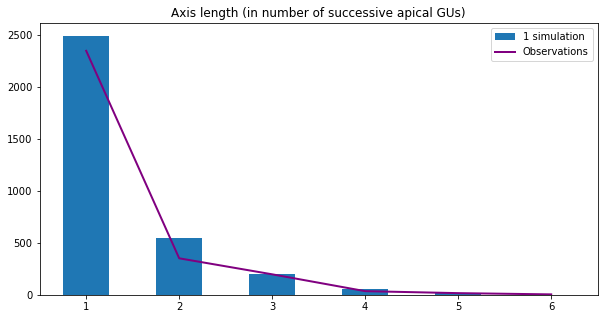

In [22]:
fig, axes = plt.subplots(figsize=(10,5))
lengthdistribution.plot.bar(ax=axes)
measuredlengthdistribution.plot.line(ax=axes, color='purple', linewidth=2, use_index=False)
_= plt.title('Axis length (in number of successive apical GUs)')

### Alternative method based on MTG. Much slower.

In [23]:
def to_mtg(ds):
    from openalea.mtg import MTG
    adjacency = np.array(ds.topology__adjacency.data)
    apical = ds.topology__is_apical
    cycle = ds.topology__cycle
    m = MTG()
    parents = list(adjacency[:, ds.GU[cycle>3]].nonzero()[0])
    mapping = {}
    for gu, parent in zip(ds.GU[cycle>3].data, parents):
        if not parent in mapping or apical[gu] == False :
            mapping[gu] = m.add_component(m.root, cycle=cycle[gu])
        else:
            mapping[gu] = m.add_child(mapping[parent], edge_type='<', cycle=cycle[gu])
    return m

def determine_length_histogram(ds):
    mtg = to_mtg(ds)
    ucs =  [uc for uc in mtg.vertices(scale=1) if mtg.property('cycle')[uc] > 3]
    def axial_axe_length(uc):
        cuc = uc
        l = 1
        parent = mtg.parent(cuc)
        while not parent is None:
            cuc = parent
            parent = mtg.parent(cuc)
            l += 1
        return l
    last_apical_ucs = [uc for uc in ucs if len(mtg.children(uc)) == 0 ]
    axial_axe_lengths = list(map(axial_axe_length, last_apical_ucs))
    histo = np.bincount(axial_axe_lengths)[1:]
    return DataFrame({'1 simulation' : histo}, index=list(range(1,1+len(histo))))

In [24]:
lengthdistribution = apply_to_all_ds(determine_length_histogram)
lengthdistribution


,1 simulation
1,2796
2,544
3,274
4,60
